In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import nltk as tk
from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings
def predict_qt(question, text):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'


    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)


    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, 

def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    print("all tokens:    ", len(all_tokens))
    
    print(torch.max(torch.softmax(end_scores[0], dim=0)), 
      torch.argmax(end_scores),
      torch.argmax(end_scores),
      torch.max(torch.softmax(start_scores[0], dim=0)))
    
    return all_tokens, attributions_start_sum



def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth , all_tokens,  = predict_qt(question,text)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, )
    
    return all_tokens, attributions_start_sum, start_scores, end_scores



In [69]:
question = "What kind of economy does Victoria have?"
text= """The economy of Victoria is highly diversified: service sectors including financial and property services, health, education, wholesale, retail, hospitality and manufacturing constitute the majority of employment. Victoria's total gross state product (GSP) is ranked second in Australia, although Victoria is ranked fourth in terms of GSP per capita because of its limited mining activity. Culturally, Melbourne is home to a number of museums, art galleries and theatres and is also described as the "sporting capital of Australia". The Melbourne Cricket Ground is the largest stadium in Australia, and the host of the 1956 Summer Olympics and the 2006 Commonwealth Games. The ground is also considered the "spiritual home" of Australian cricket and Australian rules football, and hosts the grand final of the Australian Football League (AFL) each year, usually drawing crowds of over 95,000 people. Victoria includes eight public universities, with the oldest, the University of Melbourne, having been founded in 1853."""

l_attributions = []
l_start_score = []
l_end_score = []

tokens = tk.sent_tokenize(text)
all_tokens, attributions_start_sum, start_scores, end_scores = pred_explain(question, text)
end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
l_attributions.append(torch.sum(attributions_start_sum)/len(all_tokens))
l_start_score.append(start_score)
l_end_score.append(end_score)
print("attribution average value : ", torch.sum(attributions_start_sum)/len(all_tokens))
print("start_scores :   ", start_score, " end_scores  : ", end_score)

for token in tokens:
    all_tokens, attributions_start_sum, start_scores, end_scores = pred_explain(question, token)
    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    l_attributions.append(torch.sum(attributions_start_sum)/len(all_tokens))
    l_start_score.append(start_score)
    l_end_score.append(end_score)
    print("attribution average value : ", torch.sum(attributions_start_sum)/len(all_tokens))
    print("start_scores :   ", start_score, " end_scores  : ", end_score)
    


Question:  What kind of economy does Victoria have?
Predicted Answer:  highly diversified
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'the', 'economy', 'of', 'victoria', 'is', 'highly', 'diversified', ':', 'service', 'sectors', 'including', 'financial', 'and', 'property', 'services', ',', 'health', ',', 'education', ',', 'wholesale', ',', 'retail', ',', 'hospitality', 'and', 'manufacturing', 'constitute', 'the', 'majority', 'of', 'employment', '.', 'victoria', "'", 's', 'total', 'gross', 'state', 'product', '(', 'gs', '##p', ')', 'is', 'ranked', 'second', 'in', 'australia', ',', 'although', 'victoria', 'is', 'ranked', 'fourth', 'in', 'terms', 'of', 'gs', '##p', 'per', 'capita', 'because', 'of', 'its', 'limited', 'mining', 'activity', '.', 'culturally', ',', 'melbourne', 'is', 'home', 'to', 'a', 'number', 'of', 'museums', ',', 'art', 'galleries', 'and', 'theatres', 'and', 'is', 'also', 'described', 'as', 'the', '"', 'sporting', 'capital', 'of', '

 Visualizations For End Position 
attributions_start_sum:    198
all tokens:     198
tensor(0.9074, device='cuda:0', grad_fn=<MaxBackward1>) tensor(16, device='cuda:0') tensor(16, device='cuda:0') tensor(0.7330, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(-0.0150, device='cuda:0', dtype=torch.float64)
start_scores :    0.7330169677734375  end_scores  :  0.9074357151985168
Question:  What kind of economy does Victoria have?
Predicted Answer:  highly diversified
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'the', 'economy', 'of', 'victoria', 'is', 'highly', 'diversified', ':', 'service', 'sectors', 'including', 'financial', 'and', 'property', 'services', ',', 'health', ',', 'education', ',', 'wholesale', ',', 'retail', ',', 'hospitality', 'and', 'manufacturing', 'constitute', 'the', 'majority', 'of', 'employment', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    44
all tokens:     44
tensor(0.7912, device='cuda:0', grad_fn=<MaxBackward1>) tensor(16, device='cuda:0') tensor(16, device='cuda:0') tensor(0.6163, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0707, device='cuda:0', dtype=torch.float64)
start_scores :    0.6162905693054199  end_scores  :  0.7912256121635437
Question:  What kind of economy does Victoria have?
Predicted Answer:  mining
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'victoria', "'", 's', 'total', 'gross', 'state', 'product', '(', 'gs', '##p', ')', 'is', 'ranked', 'second', 'in', 'australia', ',', 'although', 'victoria', 'is', 'ranked', 'fourth', 'in', 'terms', 'of', 'gs', '##p', 'per', 'capita', 'because', 'of', 'its', 'limited', 'mining', 'activity', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    47
all tokens:     47
tensor(0.7537, device='cuda:0', grad_fn=<MaxBackward1>) tensor(43, device='cuda:0') tensor(43, device='cuda:0') tensor(0.7653, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0330, device='cuda:0', dtype=torch.float64)
start_scores :    0.765277087688446  end_scores  :  0.7537121772766113
Question:  What kind of economy does Victoria have?
Predicted Answer:  sporting
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'culturally', ',', 'melbourne', 'is', 'home', 'to', 'a', 'number', 'of', 'museums', ',', 'art', 'galleries', 'and', 'theatres', 'and', 'is', 'also', 'described', 'as', 'the', '"', 'sporting', 'capital', 'of', 'australia', '"', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    39
all tokens:     39
tensor(0.2737, device='cuda:0', grad_fn=<MaxBackward1>) tensor(32, device='cuda:0') tensor(32, device='cuda:0') tensor(0.6017, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0394, device='cuda:0', dtype=torch.float64)
start_scores :    0.6016721725463867  end_scores  :  0.273728609085083
Question:  What kind of economy does Victoria have?
Predicted Answer:  melbourne cricket ground is the largest stadium in australia
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'the', 'melbourne', 'cricket', 'ground', 'is', 'the', 'largest', 'stadium', 'in', 'australia', ',', 'and', 'the', 'host', 'of', 'the', '1956', 'summer', 'olympics', 'and', 'the', '2006', 'commonwealth', 'games', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    36
all tokens:     36
tensor(0.3220, device='cuda:0', grad_fn=<MaxBackward1>) tensor(19, device='cuda:0') tensor(19, device='cuda:0') tensor(0.3908, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(-0.0055, device='cuda:0', dtype=torch.float64)
start_scores :    0.390794038772583  end_scores  :  0.3220273554325104
Question:  What kind of economy does Victoria have?
Predicted Answer:  
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'the', 'ground', 'is', 'also', 'considered', 'the', '"', 'spiritual', 'home', '"', 'of', 'australian', 'cricket', 'and', 'australian', 'rules', 'football', ',', 'and', 'hosts', 'the', 'grand', 'final', 'of', 'the', 'australian', 'football', 'league', '(', 'afl', ')', 'each', 'year', ',', 'usually', 'drawing', 'crowds', 'of', 'over', '95', ',', '000', 'people', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    55
all tokens:     55
tensor(0.0942, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0.2666, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0034, device='cuda:0', dtype=torch.float64)
start_scores :    0.2666054666042328  end_scores  :  0.094185009598732
Question:  What kind of economy does Victoria have?
Predicted Answer:  public
['[CLS]', 'what', 'kind', 'of', 'economy', 'does', 'victoria', 'have', '?', '[SEP]', 'victoria', 'includes', 'eight', 'public', 'universities', ',', 'with', 'the', 'oldest', ',', 'the', 'university', 'of', 'melbourne', ',', 'having', 'been', 'founded', 'in', '1853', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    32
all tokens:     32
tensor(0.8753, device='cuda:0', grad_fn=<MaxBackward1>) tensor(13, device='cuda:0') tensor(13, device='cuda:0') tensor(0.9544, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0455, device='cuda:0', dtype=torch.float64)
start_scores :    0.9543848037719727  end_scores  :  0.8753281235694885


In [74]:
li = []
for i in l_attributions:
    temp = torch.Tensor.cpu(i)
    li.append(temp)
l_attributions = li

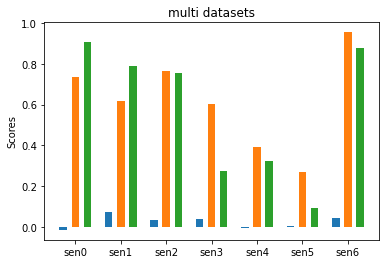

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

label = []
for i in range(len(l_attributions)):
    label.append("sen" + str(i))


data = [l_attributions, l_start_score, l_end_score]


def create_multi_bars(labels, datas, tick_step=1, group_gap=0.2, bar_gap=0):
    '''
    labels : x轴坐标标签序列
    datas ：数据集，二维列表，要求列表每个元素的长度必须与labels的长度一致
    tick_step ：默认x轴刻度步长为1，通过tick_step可调整x轴刻度步长。
    group_gap : 柱子组与组之间的间隙，最好为正值，否则组与组之间重叠
    bar_gap ：每组柱子之间的空隙，默认为0，每组柱子紧挨，正值每组柱子之间有间隙，负值每组柱子之间重叠
    '''
    # ticks为x轴刻度
    ticks = np.arange(len(labels)) * tick_step
    # group_num为数据的组数，即每组柱子的柱子个数
    group_num = len(datas)
    # group_width为每组柱子的总宽度，group_gap 为柱子组与组之间的间隙。
    group_width = tick_step - group_gap
    # bar_span为每组柱子之间在x轴上的距离，即柱子宽度和间隙的总和
    bar_span = group_width / group_num
    # bar_width为每个柱子的实际宽度
    bar_width = bar_span - bar_gap
    # baseline_x为每组柱子第一个柱子的基准x轴位置，随后的柱子依次递增bar_span即可
    baseline_x = ticks - (group_width - bar_span) / 2
    for index, y in enumerate(datas):
        plt.bar(baseline_x + index*bar_span, y, bar_width)
    plt.ylabel('Scores')
    plt.title('multi datasets')
    # x轴刻度标签位置与x轴刻度一致
    plt.xticks(ticks, labels)
    plt.show()
    

create_multi_bars(label, data, bar_gap=0.1)


In [4]:
import nltk as tk
question = "What kind of economy does Victoria have?"
text= """The economy of Victoria is highly diversified: service sectors including financial and property services, health, education, wholesale, retail, hospitality and manufacturing constitute the majority of employment. Victoria's total gross state product (GSP) is ranked second in Australia, although Victoria is ranked fourth in terms of GSP per capita because of its limited mining activity. Culturally, Melbourne is home to a number of museums, art galleries and theatres and is also described as the "sporting capital of Australia". The Melbourne Cricket Ground is the largest stadium in Australia, and the host of the 1956 Summer Olympics and the 2006 Commonwealth Games. The ground is also considered the "spiritual home" of Australian cricket and Australian rules football, and hosts the grand final of the Australian Football League (AFL) each year, usually drawing crowds of over 95,000 people. Victoria includes eight public universities, with the oldest, the University of Melbourne, having been founded in 1853."""
print(text)
print("*"*144)

tokens = tk.sent_tokenize(text)

for token in tokens:
    print(token)
    print("-"*144)
    

The economy of Victoria is highly diversified: service sectors including financial and property services, health, education, wholesale, retail, hospitality and manufacturing constitute the majority of employment. Victoria's total gross state product (GSP) is ranked second in Australia, although Victoria is ranked fourth in terms of GSP per capita because of its limited mining activity. Culturally, Melbourne is home to a number of museums, art galleries and theatres and is also described as the "sporting capital of Australia". The Melbourne Cricket Ground is the largest stadium in Australia, and the host of the 1956 Summer Olympics and the 2006 Commonwealth Games. The ground is also considered the "spiritual home" of Australian cricket and Australian rules football, and hosts the grand final of the Australian Football League (AFL) each year, usually drawing crowds of over 95,000 people. Victoria includes eight public universities, with the oldest, the University of Melbourne, having bee